## Yelp Review Text Analysis using RNN 

## Text Preprocess

In [2]:
import pandas as pd
import string
import re
import nltk
from nltk.tokenize import TweetTokenizer

In [3]:
label_data=pd.read_csv("yelp_review_with_labels.csv")

In [4]:
label_data["text"][0]

"Went here for all you can eat sushi dinner! Bottomline: best all you can eat sushi in Calgary! It costs $26 per person for sushi and sashimi and $32 for the deluxe menu which includes oysters and tataki. \n\nWe went a little overboard with ordering rolls (to the point that the waiter asked if we were sure we can finish haha) and then regretted it shortly after! There is a charge for unfinished food so it was a little stressful haha \n\nWe ordered the mango dragon roll (prawn tempura and avacado with mango), Philadelphia roll, spicy salmon roll, beef udon, miso soup, salmon and tuna sashimi, salmon rose and prawn tempura. Out of these my favourites were the spicy salmon and the mango dragon roll. I didn't love the tempura personally because it was a bit soggy. Didn't have room for dessert after all this food so can't comment on that haha"

In [5]:
def clean_text(text):
    # remove numbers
    text_nonum = re.sub(r'\d+', '', text)
    # remove punctuations and convert characters to lower case
    text_nopunct = "".join([char for char in text_nonum if char not in string.punctuation]) 
    # substitute multiple whitespace with single whitespace
    # remove leading and trailing whitespaces
    text_no_doublespace = re.sub('\s+', ' ', text_nopunct).strip()
    return text_no_doublespace

label_data["text"]=label_data['text'].map(lambda text: clean_text(text))

In [6]:
label_data["text"][0]

'Went here for all you can eat sushi dinner Bottomline best all you can eat sushi in Calgary It costs per person for sushi and sashimi and for the deluxe menu which includes oysters and tataki We went a little overboard with ordering rolls to the point that the waiter asked if we were sure we can finish haha and then regretted it shortly after There is a charge for unfinished food so it was a little stressful haha We ordered the mango dragon roll prawn tempura and avacado with mango Philadelphia roll spicy salmon roll beef udon miso soup salmon and tuna sashimi salmon rose and prawn tempura Out of these my favourites were the spicy salmon and the mango dragon roll I didnt love the tempura personally because it was a bit soggy Didnt have room for dessert after all this food so cant comment on that haha'

In [7]:
#lowercase conversion  
label_data['text'] = [i.lower() for i in label_data['text']]

#stopword removal 
from nltk.corpus import stopwords
nltk.download('stopwords')

Stopwords = set(stopwords.words('english'))

label_data["text"] = label_data["text"].apply(lambda text: " ".join([word for word in str(text).split() if word not in Stopwords]))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sophia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
label_data["text"][0]

'went eat sushi dinner bottomlin best eat sushi calgari cost per person sushi sashimi delux menu includ oyster tataki went littl overboard order roll point waiter ask sure finish haha regret shortli charg unfinish food littl stress haha order mango dragon roll prawn tempura avacado mango philadelphia roll spici salmon roll beef udon miso soup salmon tuna sashimi salmon rose prawn tempura favourit spici salmon mango dragon roll didnt love tempura person bit soggi didnt room dessert food cant comment haha'

In [8]:
#lemmatization
nltk.download('wordnet')
from textblob import Word
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer()

# Lemmatize final review format
label_data['text'] = label_data['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

[nltk_data] Downloading package wordnet to /Users/sophia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
#stemming
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()

label_data["text"] = label_data["text"].apply(lambda text: " ".join([stemmer.stem(word) for word in text.split()]))

In [10]:
label_data['text'][0]

'went eat sushi dinner bottomlin best eat sushi calgari cost per person sushi sashimi delux menu includ oyster tataki went littl overboard order roll point waiter ask sure finish haha regret shortli charg unfinish food littl stress haha order mango dragon roll prawn tempura avacado mango philadelphia roll spici salmon roll beef udon miso soup salmon tuna sashimi salmon rose prawn tempura favourit spici salmon mango dragon roll didnt love tempura person bit soggi didnt room dessert food cant comment haha'

In [11]:
#split train and test dataset
X=label_data["text"]
X.head(5)

0    went eat sushi dinner bottomlin best eat sushi...
1    servic okay present menu particularli eat sush...
2    went weekend lunch foodservic fantast never ay...
3    ive eaten twice im realli impress get lot pric...
4    good group came tonight birthday dinner group ...
Name: text, dtype: object

In [12]:
y=label_data["polarity"]
y.head(5)

0    0
1    0
2    1
3    1
4    0
Name: polarity, dtype: int64

In [13]:
#split train and test dataset
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1)

In [14]:
from keras.preprocessing.text import Tokenizer
# Number of words to consider as features
# restrict the yelp reviews to the top 10000 most common words
max_features=10000

Using TensorFlow backend.


In [15]:
# Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train)+list(X_test))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [16]:
from keras.preprocessing.sequence import pad_sequences
# cut reviews after 200 words
maxlen=200
X_train=pad_sequences(X_train,maxlen=maxlen) #training data contains a list of list of numbers 
X_test=pad_sequences(X_test,maxlen=maxlen) #each list has the same numbers 

In [17]:
print("X_train",X_train.shape)
print("y_train",y_train.shape)

X_train (11738, 200)
y_train (11738,)


In [17]:
print("X_test",X_test.shape)
print("y_test",y_test.shape)

X_test (5031, 200)
y_test (5031,)


## Baseline: Multinomial Naive Bayes

In [52]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [53]:
preds = nb.predict(X_test)

In [54]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, preds))
print('\n')
print(classification_report(y_test, preds))

[[ 356 1372]
 [ 498 2805]]


              precision    recall  f1-score   support

           0       0.42      0.21      0.28      1728
           1       0.67      0.85      0.75      3303

    accuracy                           0.63      5031
   macro avg       0.54      0.53      0.51      5031
weighted avg       0.58      0.63      0.59      5031



## Model 1: Embedding layer + LSTM

In [26]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Embedding, Dense,Dropout,LSTM,Bidirectional
from keras.optimizers import RMSprop
from keras import backend as K
from tensorflow.keras import regularizers

import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
max_words = 10000 
maxlen = 200
model = Sequential()
model.add(Embedding(max_words, 64,input_length = maxlen))
model.add(LSTM(64,dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 64)           640000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 673,089
Trainable params: 673,089
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

/Users/sophia/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 9390 samples, validate on 2348 samples
Epoch 1/10
9390/9390 [==============================] - 13s 1ms/step - loss: 0.5475 - acc: 0.7225 - val_loss: 0.4529 - val_acc: 0.7922
Epoch 2/10
9390/9390 [==============================] - 13s 1ms/step - loss: 0.3943 - acc: 0.8285 - val_loss: 0.3966 - val_acc: 0.8130
Epoch 3/10
9390/9390 [==============================] - 12s 1ms/step - loss: 0.3244 - acc: 0.8650 - val_loss: 0.3776 - val_acc: 0.8352
Epoch 4/10
9390/9390 [==============================] - 12s 1ms/step - loss: 0.2761 - acc: 0.8883 - val_loss: 0.3972 - val_acc: 0.8101
Epoch 5/10
9390/9390 [==============================] - 12s 1ms/step - loss: 0.2509 - acc: 0.8987 - val_loss: 0.4183 - val_acc: 0.8224
Epoch 6/10
9390/9390 [==============================] - 12s 1ms/step - loss: 0.2333 - acc: 0.9116 - val_loss: 0.4453 - val_acc: 0.8177
Epoch 7/10
9390/9390 [==============================] - 12s 1ms/step - loss: 0.2088 - acc: 0.9206 - val_loss: 0.4325 - val_acc: 0.8203
Epoch 8

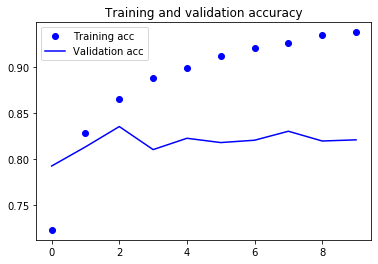

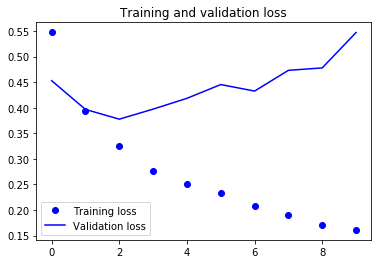

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [35]:
model.metrics_names

['loss', 'acc']

In [34]:
#model evaluation on test data
print(f"model loss is {model.evaluate(X_test,y_test)[0]}")
print(f"model accuracy is {model.evaluate(X_test,y_test)[1]}")

5031/5031 [==============================] - 2s 457us/step
model loss is 0.8252036579855155
5031/5031 [==============================] - 2s 427us/step
model accuracy is 0.803021252155304


Summary: with LSTM, dropout and recurrent drop, the model is significantly overfitting after the second epoch.

## Model 2: Embedding layer + Bidirectional LSTM

In [19]:
from keras import backend as K
K.clear_session()

In [26]:
model_2 = Sequential()
model_2.add(Embedding(max_words, 128, input_length=maxlen))
model_2.add(Bidirectional(LSTM(128,dropout=0.2, recurrent_dropout=0.2)))
model_2.add(Dense(1, activation='sigmoid'))
model_2.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 128)          1280000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 1,543,425
Trainable params: 1,543,425
Non-trainable params: 0
_________________________________________________________________


In [27]:
history_2 = model_2.fit(X_train, y_train, 
                    epochs=10, 
                    batch_size=128, 
                    validation_split=0.2)

Train on 9390 samples, validate on 2348 samples
Epoch 1/10
9390/9390 [==============================] - 12s 1ms/step - loss: 0.1491 - acc: 0.9413 - val_loss: 0.6420 - val_acc: 0.8152
Epoch 2/10
9390/9390 [==============================] - 12s 1ms/step - loss: 0.1360 - acc: 0.9502 - val_loss: 0.5669 - val_acc: 0.8143
Epoch 3/10
9390/9390 [==============================] - 12s 1ms/step - loss: 0.1251 - acc: 0.9537 - val_loss: 0.6665 - val_acc: 0.8079
Epoch 4/10
9390/9390 [==============================] - 12s 1ms/step - loss: 0.1217 - acc: 0.9550 - val_loss: 0.7198 - val_acc: 0.8130
Epoch 5/10
9390/9390 [==============================] - 12s 1ms/step - loss: 0.1103 - acc: 0.9573 - val_loss: 0.5971 - val_acc: 0.8062
Epoch 6/10
9390/9390 [==============================] - 12s 1ms/step - loss: 0.1068 - acc: 0.9616 - val_loss: 0.5981 - val_acc: 0.7951
Epoch 7/10
9390/9390 [==============================] - 12s 1ms/step - loss: 0.0952 - acc: 0.9655 - val_loss: 0.6517 - val_acc: 0.8054
Epoch 8

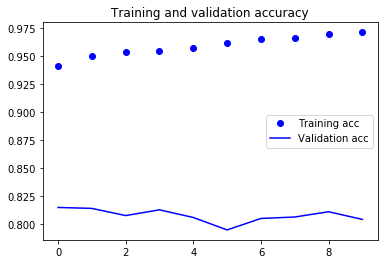

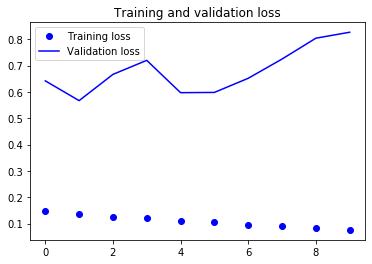

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history_2.history['acc']
val_acc = history_2.history['val_acc']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [51]:
#model evaluation on test data
print(f"model loss is {model_2.evaluate(X_test,y_test)[0]}")
print(f"model accuracy is {model_2.evaluate(X_test,y_test)[1]}")

5031/5031 [==============================] - 7s 1ms/step
model loss is 0.6936143260783122
5031/5031 [==============================] - 9s 2ms/step
model accuracy is 0.4581594169139862


## Model 3: Embedding Layer + LSTM(32)
* accuracy: 0.81792

In [44]:
from tensorflow.keras import regularizers

In [45]:
K.clear_session()

In [61]:
max_words = 10000 
maxlen = 200
model = Sequential()
model.add(Embedding(max_words, 32,input_length = maxlen))
#output shape(batch_size,timestep,units)
model.add(LSTM(32,dropout=0.3, recurrent_dropout=0.3,recurrent_regularizer=regularizers.l2(0.01),return_sequences=True))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 32)           320000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 200, 32)           8320      
_________________________________________________________________
dense_3 (Dense)              (None, 200, 1)            33        
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________


In [48]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

/Users/sophia/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 9390 samples, validate on 2348 samples
Epoch 1/10
9390/9390 [==============================] - 12s 1ms/step - loss: 0.5461 - acc: 0.7226 - val_loss: 0.4594 - val_acc: 0.7756
Epoch 2/10
9390/9390 [==============================] - 12s 1ms/step - loss: 0.3947 - acc: 0.8249 - val_loss: 0.3951 - val_acc: 0.8250
Epoch 3/10
9390/9390 [==============================] - 12s 1ms/step - loss: 0.3295 - acc: 0.8610 - val_loss: 0.3876 - val_acc: 0.8241
Epoch 4/10
9390/9390 [==============================] - 12s 1ms/step - loss: 0.2811 - acc: 0.8874 - val_loss: 0.3970 - val_acc: 0.8267
Epoch 5/10
9390/9390 [==============================] - 12s 1ms/step - loss: 0.2515 - acc: 0.8968 - val_loss: 0.4162 - val_acc: 0.8101
Epoch 6/10
9390/9390 [==============================] - 12s 1ms/step - loss: 0.2282 - acc: 0.9052 - val_loss: 0.4241 - val_acc: 0.8041
Epoch 7/10
9390/9390 [==============================] - 12s 1ms/step - loss: 0.2090 - acc: 0.9162 - val_loss: 0.4331 - val_acc: 0.8096
Epoch 8

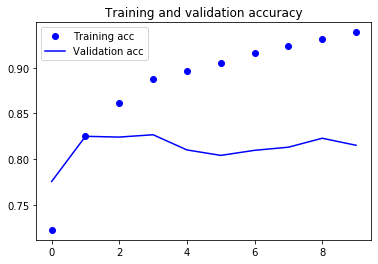

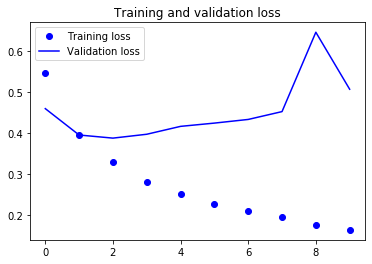

In [49]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [50]:
#model evaluation on test data
print(f"model loss is {model.evaluate(X_test,y_test)[0]}")
print(f"model accuracy is {model.evaluate(X_test,y_test)[1]}")

5031/5031 [==============================] - 2s 441us/step
model loss is 0.4973128602764664
5031/5031 [==============================] - 2s 424us/step
model accuracy is 0.8179288506507874


## Test Model 3
* accuracy: 0.81176

In [55]:
K.clear_session()
max_words = 10000 
maxlen = 200
model_3 = Sequential()
model_3.add(Embedding(max_words, 32,input_length = maxlen))
model_3.add(LSTM(32,dropout=0.3, recurrent_dropout=0.3,recurrent_regularizer=regularizers.l2(0.01)))
model_3.add(Dense(1, activation='sigmoid'))

model_3.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model_3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 32)           320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________


In [56]:
history_3 = model_3.fit(X_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

/Users/sophia/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 9390 samples, validate on 2348 samples
Epoch 1/10
9390/9390 [==============================] - 8s 859us/step - loss: 0.7734 - acc: 0.6647 - val_loss: 0.6041 - val_acc: 0.7317
Epoch 2/10
9390/9390 [==============================] - 8s 833us/step - loss: 0.5172 - acc: 0.7923 - val_loss: 0.4735 - val_acc: 0.7943
Epoch 3/10
9390/9390 [==============================] - 8s 814us/step - loss: 0.4226 - acc: 0.8260 - val_loss: 0.4521 - val_acc: 0.7973
Epoch 4/10
9390/9390 [==============================] - 8s 811us/step - loss: 0.3721 - acc: 0.8507 - val_loss: 0.4334 - val_acc: 0.8062
Epoch 5/10
9390/9390 [==============================] - 8s 813us/step - loss: 0.3331 - acc: 0.8701 - val_loss: 0.4400 - val_acc: 0.7968
Epoch 6/10
9390/9390 [==============================] - 7s 753us/step - loss: 0.3037 - acc: 0.8865 - val_loss: 0.4344 - val_acc: 0.8139
Epoch 7/10
9390/9390 [==============================] - 7s 766us/step - loss: 0.2865 - acc: 0.8935 - val_loss: 0.4481 - val_acc: 0.8109


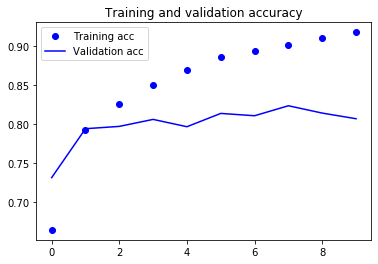

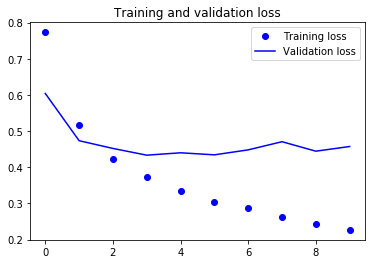

In [57]:
acc = history_3.history['acc']
val_acc = history_3.history['val_acc']
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [58]:
#model evaluation on test data
print(f"model loss is {model_3.evaluate(X_test,y_test)[0]}")
print(f"model accuracy is {model_3.evaluate(X_test,y_test)[1]}")

5031/5031 [==============================] - 2s 335us/step
model loss is 0.45575253732681653
5031/5031 [==============================] - 2s 353us/step
model accuracy is 0.811767041683197


## Model 4: 
* add dropout layer before LSTM with 0.5
* decrease epoch to 32
* metrics: accuracy/precison/recall 

In [20]:
K.clear_session()

In [23]:
max_words = 10000 
maxlen = 200
model= Sequential()
model.add(Embedding(max_words, 32,input_length = maxlen))
model.add(Dropout(0.5))
model.add(LSTM(32,dropout=0.3, recurrent_dropout=0.3,recurrent_regularizer=regularizers.l2(0.01)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 32)           320000    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________


In [24]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

/Users/sophia/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 9390 samples, validate on 2348 samples
Epoch 1/10
9390/9390 [==============================] - 26s 3ms/step - loss: 0.6466 - acc: 0.6983 - val_loss: 0.4914 - val_acc: 0.7858
Epoch 2/10
9390/9390 [==============================] - 24s 3ms/step - loss: 0.4712 - acc: 0.7914 - val_loss: 0.4379 - val_acc: 0.8109
Epoch 3/10
9390/9390 [==============================] - 24s 3ms/step - loss: 0.4243 - acc: 0.8165 - val_loss: 0.4341 - val_acc: 0.8020
Epoch 4/10
9390/9390 [==============================] - 24s 3ms/step - loss: 0.3935 - acc: 0.8340 - val_loss: 0.4156 - val_acc: 0.8109
Epoch 5/10
9390/9390 [==============================] - 24s 3ms/step - loss: 0.3745 - acc: 0.8441 - val_loss: 0.4006 - val_acc: 0.8211
Epoch 6/10
9390/9390 [==============================] - 24s 3ms/step - loss: 0.3588 - acc: 0.8521 - val_loss: 0.4046 - val_acc: 0.8292
Epoch 7/10
9390/9390 [==============================] - 24s 3ms/step - loss: 0.3478 - acc: 0.8550 - val_loss: 0.4035 - val_acc: 0.8365
Epoch 8

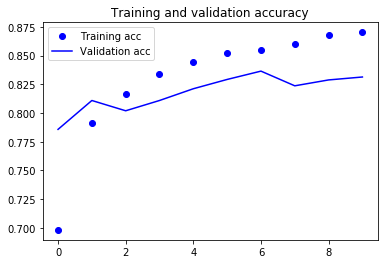

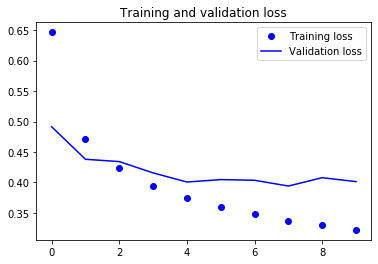

In [27]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [28]:
#model evaluation on test data
print(f"model loss is {model.evaluate(X_test,y_test)[0]}")
print(f"model accuracy is {model.evaluate(X_test,y_test)[1]}")

5031/5031 [==============================] - 2s 357us/step
model loss is 0.41547058263537756
5031/5031 [==============================] - 2s 350us/step
model accuracy is 0.8278672099113464


In [45]:
from sklearn.metrics import classification_report,precision_score,recall_score
import numpy as np

y_pred = model.predict(X_test, batch_size=32, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))

5031/5031 [==============================] - 2s 380us/step
              precision    recall  f1-score   support

           0       0.34      1.00      0.51      1728
           1       0.00      0.00      0.00      3303

    accuracy                           0.34      5031
   macro avg       0.17      0.50      0.26      5031
weighted avg       0.12      0.34      0.18      5031



/Users/sophia/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [46]:
y_pred_hat = model.predict_classes(X_test,verbose=0)
print(precision_score(y_test, y_pred_hat))
print(recall_score(y_test, y_pred_hat))

0.8553514144065325
0.8879806236754466


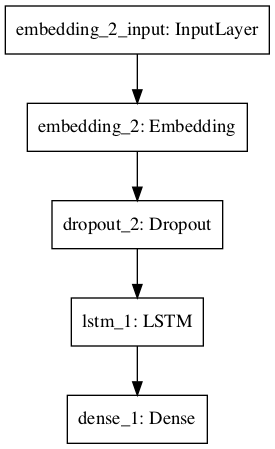

In [36]:
#visualize model design
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [39]:
#create df w/ train and val acc
import pandas as pd 
train_acc=history.history['acc']
test_acc=history.history['val_acc']
df=pd.DataFrame()
df['train_acc']=train_acc
df['test_acc']=test_acc
df

,train_acc,test_acc
0,0.698296,0.785775
1,0.791374,0.810903
2,0.816507,0.801959
3,0.833972,0.810903
4,0.844089,0.821124
5,0.852077,0.829216
6,0.854952,0.836457
7,0.860383,0.823680
8,0.868158,0.828790
9,0.870288,0.831346


In [40]:
df.to_csv("rnn_acc.csv")

In [ ]:
sklearn.metrics.precision_score